## Importing Libraries

In [204]:
import json
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pprint

## Business Dataset

In [115]:
businesses = pd.read_json('business.json', lines = True)
restaurants = businesses.drop(businesses[businesses.categories.str.contains('Restaurants') == False].index) # 59853 Restaurants
restaurants = restaurants[['business_id', 'name', 'city', 'state', 'review_count', 'stars']]
restaurants.to_csv('restaurants.csv', index = False)

## Review Dataset

Exporting full dataset to csv (estimated time: ~ 6 hours)

In [ ]:
# reviews: 'review_id', 'user_id', 'business_id', 'stars', 'date'
header_df = pd.DataFrame(columns=['review_id', 'user_id', 'business_id', 'stars', 'date'])
header_df.to_csv('restaurant_reviews.csv')
restaurant_business_ids = list(restaurants['business_id'])

chunk_size = 100000
num_checked = 0
num_reviews = 0
i = 0
chunk_dict = {}

with open('review.json', 'r', errors = 'ignore') as file:
    for line in file:
        if num_checked % chunk_size == 0:
            chunk_df = pd.DataFrame.from_dict(chunk_dict, orient = 'index')
            chunk_df.to_csv('restaurant_reviews.csv', mode = 'a', header = False, index = False)
            chunk_dict = {}
            chunk_df.drop(chunk_df.index, inplace=True)
            i = 0
            clear_output()
            print(str(num_checked / 66859)[:4] + '% done, ' + str(num_reviews) + ' reviews in dataframe at ' + time.ctime())
        review = json.loads(line)
        num_checked += 1
        if review['business_id'] in restaurant_business_ids:
            i += 1
            num_reviews += 1
            chunk_dict[i] = {'review_id': review['review_id'], 
                             'user_id': review['user_id'],
                             'business_id': review['business_id'],
                             'stars': review['stars'],
                             'date': review['date']}

Taking sample of restaurants and getting all the respective reviews

In [ ]:
restaurant_business_ids = list(restaurants['business_id'])[:100]
reviews_df = pd.DataFrame(columns = ['review_id', 'user_id', 'business_id', 'stars', 'date'])
num_checked = 0
with open('review.json', 'r', errors = 'ignore') as file:
    for line in file:
        review = json.loads(line)
        num_checked += 1
        if num_checked % 10000 == 0:
            clear_output()
            print(str(num_checked / 66859)[:4] + '% done, ' + str(len(reviews_df.index)) + ' reviews in dataframe')
        if review['business_id'] in restaurant_business_ids:
            reviews_df = reviews_df.append({'review_id': review['review_id'], 
                                            'user_id': review['user_id'],
                                            'business_id': review['business_id'],
                                            'stars': review['stars'],
                                            'date': review['date']}, ignore_index = True)

## User Dataset

In [ ]:
# users: 'user_id', 'review_count', 'elite', 'yelping_since', 'average_stars'

users_df = pd.DataFrame(columns = ['user_id', 'review_count', 'elite', 'yelping_since', 'avergae_stars'])
users_df.to_csv('users.csv')

chunk_size = 100000
num_users = 0
i = 0
chunk_dict = {}

with open('user.json', 'r', errors = 'ignore') as file:
    for line in file:
        if num_users % chunk_size == 0:
            chunk_df = pd.DataFrame.from_dict(chunk_dict, orient = 'index')
            chunk_df.to_csv('users.csv', mode = 'a', header = False, index = False)
            chunk_dict = {}
            chunk_df.drop(chunk_df.index, inplace=True)
            i = 0
            clear_output()
            print(str(num_users / 66859)[:4] + '% done, ' + str(num_users) + ' users in dataframe at ' + time.ctime())
        user = json.loads(line)
        i += 1
        num_users += 1
        chunk_dict[i] = {'user_id': user['user_id'], 
                         'review_count': user['review_count'],
                         'elite': user['elite'],
                         'yelping_since': user['yelping_since'],
                         'average_stars': user['average_stars']}

In [ ]:
# Make user dataset into a dictionary where the user id is the key. Then iterate through reviews and find the user
# to check whether the user was elite in the review date year

# Analysis

## Sampling

In [174]:
restaurants = pd.read_csv('restaurants.csv')
# median is 20
restaurants = restaurants[restaurants['review_count'] > 20]
sample_restaurants = restaurants.sample(100, random_state = 5)

In [180]:
sample_restaurant_business_ids = list(sample_restaurants['business_id'])
sample_reviews_df = pd.DataFrame(columns = ['review_id', 'user_id', 'business_id', 'stars', 'date'])
num_checked = 0


reviews = pd.read_csv('restaurant_reviews.csv')
for index, review in reviews.iterrows():
    if index % 100000 == 0:
        clear_output()
        print(str(index / 41538)[:4] + '% done, ' + str(len(sample_reviews_df.index)) + ' reviews in dataframe at ' + time.ctime())
    if review.business_id in sample_restaurant_business_ids:
        sample_reviews_df = sample_reviews_df.append(review)

101.% done, 12586 reviews in dataframe at Tue Feb 12 16:13:18 2019


In [188]:
sample_restaurants.to_csv('sampled_restaurants.csv', index = False)
sample_reviews_df.to_csv('sampled_restaurant_reviews.csv', index = False)

Creating dictionary of business_id's to business objects and lists of associated reviews

In [ ]:
sample_restaurants = pd.read_csv('sampled_restaurants.csv')
sample_reviews = pd.read_csv('sampled_restaurant_reviews.csv')

restaurant_dict = {}
for i, restaurant in sample_restaurants.iterrows():
    reviews = []
    for j, review in sample_reviews.iterrows():
        if review.business_id == restaurant.business_id:
            reviews.append(review.to_dict())
    restaurant_dict[restaurant.business_id] = {'restaurant': restaurant.to_dict(), 'reviews': reviews}

In [213]:
pp = pprint.PrettyPrinter(indent=2)

pp.pprint(restaurant_dict[list(restaurant_dict.keys())[4]])

{ 'restaurant': { 'business_id': 'H7z0JH-i_KqhrsZhEDBpVA',
                  'city': 'Toronto',
                  'name': 'Dominion Pub and Kitchen',
                  'review_count': 40,
                  'stars': 3.5,
                  'state': 'ON'},
  'reviews': [ { 'business_id': 'H7z0JH-i_KqhrsZhEDBpVA',
                 'date': '2016-09-06 03:32:54',
                 'review_id': 'FRub3k-YeYtJpSmhBROU4w',
                 'stars': 5.0,
                 'user_id': 'D92snVFOZrBQjGyAuuz-8Q'},
               { 'business_id': 'H7z0JH-i_KqhrsZhEDBpVA',
                 'date': '2016-01-17 16:41:43',
                 'review_id': '3nqYT7D9NlcAlgA8qHTJOA',
                 'stars': 2.0,
                 'user_id': 'qHwj63QRTu_rWWGMNuoQlg'},
               { 'business_id': 'H7z0JH-i_KqhrsZhEDBpVA',
                 'date': '2016-01-04 15:43:04',
                 'review_id': 'vhpsPBL-jMuw-BZGU77m4A',
                 'stars': 4.0,
                 'user_id': '6Bai1MguJ1jVOY1wZliCUw'},
  

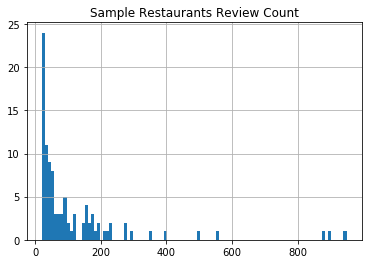

In [185]:
sample_restaurants.review_count.hist(bins = 100)
plt.title('Sample Restaurants Review Count')

In [186]:
len(sample_reviews_df.index)

12597